In [71]:
import pandas as pd
pd.set_option('display.max_rows', 500)
import os

In [72]:
PATH = "../00_data/0_raw/"
all_files = [f for f in os.listdir(PATH)] #get all file names
sorted_files = sorted(os.listdir(PATH))

#use file names as column names for later
def new_col_names(name):
    #print(os.path.basename(name).split('.')[0].replace('-', '_'))
    return os.path.basename(name).split('.')[0].replace('-', '_')

#make label u5mr first (child-mortality at position 1)
label_file = sorted_files.pop(1)
sorted_files.insert(0, label_file)

In [73]:
big_df = None
joins = ['Entity', 'Code', 'Year']

EXCLUDE_NO_COUNTRIES = ["Africa", "Asia", "Europe", "European Union (27)", "High-income countries", "Low-income countries", "Lower-middle-income countries", 
                      "North America", "Oceania", "South America", "Upper-middle-income countries", "World"]

#change column names and add as columns to df
for name in sorted_files:
    cols_names = new_col_names(name)

    df = pd.read_csv(os.path.join(PATH, name), usecols=[0, 1, 2, 3])
    df.columns = joins + [cols_names]

    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html
    df = df[~df['Entity'].isin(EXCLUDE_NO_COUNTRIES)] #remove continents etc. from df
    
    df = df.set_index(joins) #entity, code, year as index

    if big_df is None:
        big_df = df.copy() 
    else: #outer left join - merge all dfs
        big_df = big_df.merge(
            df, 
            left_index=True, 
            right_index=True, 
            how='left' 
        )

#big_df.loc[("Ghana")].head(15)
big_df.info()
#big_df.shape
#big_df.isnull().sum()
#big_df.head(450)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13038 entries, ('Afghanistan', 'AFG', np.int64(1957)) to ('Zimbabwe', 'ZWE', np.int64(2023))
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   child_mortality_igme                      13038 non-null  float64
 1   annual_healthcare_expenditure_per_capita  4357 non-null   float64
 2   gdp_per_capita_worldbank                  6299 non-null   float64
 3   nurses_and_midwives_per_1000_people       3109 non-null   float64
 4   physicians_per_1000_people                4986 non-null   float64
 5   prevalence_of_undernourishment            3661 non-null   float64
 6   share_of_population_urban                 11580 non-null  float64
 7   share_without_improved_water              4433 non-null   float64
 8   vaccination_coverage_who_unicef           7897 non-null   float64
 9   years_of_schooling                    

In [74]:
# which 6 year span has least NaN values for whole df, start from 2000 => 'cause where MDG goals started (most current years)
# between 2000 and 2019 find the 6 year period to use for later as main df, after can be more biased cause of Corona period
# so i can have a argument for my thesis in "Methodik"
# Zeitraum: 2000 - 2019, loop in 6 year periods (2000-2005, 2001-2006, 2002-2007 ... 2013-2018...)
# Note: auch von 1960 aus betrachtet ist 2013-2018 der Zeitraum mit den wenigsten Null Values 
nan_count = 0
df_period = big_df.copy()
year_val = df_period.index.get_level_values(2)

for year_start in range(2000,2015):
    year_end = year_start + 5
    # get filtered df for each period 
    df_filtered = df_period[(year_val >= year_start) & (year_val <= year_end)]
    # get number of all NaNs and print
    nan_count = df_filtered.isna().sum().sum()
    print(f"From {year_start} - {year_end}, NaN values count: {nan_count}")

From 2000 - 2005, NaN values count: 2003
From 2001 - 2006, NaN values count: 1813
From 2002 - 2007, NaN values count: 1763
From 2003 - 2008, NaN values count: 1672
From 2004 - 2009, NaN values count: 1586
From 2005 - 2010, NaN values count: 1590
From 2006 - 2011, NaN values count: 1562
From 2007 - 2012, NaN values count: 1524
From 2008 - 2013, NaN values count: 1479
From 2009 - 2014, NaN values count: 1463
From 2010 - 2015, NaN values count: 1447
From 2011 - 2016, NaN values count: 1423
From 2012 - 2017, NaN values count: 1368
From 2013 - 2018, NaN values count: 1273
From 2014 - 2019, NaN values count: 1285


In [75]:
# 2013 - 2018 has least NaN vals, take as main starting dataframe
df_main_period = df_period[(year_val >= 2013) & (year_val <= 2018)]
df_main_period.isna().sum().sum()

np.int64(1273)

In [76]:
#turn Entity into col
df_main_period = df_main_period.reset_index(level=0)
df_main_period

Entity  child_mortality_igme  \
Code Year                                      
AFG  2013  Afghanistan              7.802299   
     2014  Afghanistan              7.512363   
     2015  Afghanistan              7.243871   
     2016  Afghanistan              6.997004   
     2017  Afghanistan              6.763737   
...                ...                   ...   
ZWE  2014     Zimbabwe              6.177143   
     2015     Zimbabwe              5.976391   
     2016     Zimbabwe              5.691236   
     2017     Zimbabwe              5.495380   
     2018     Zimbabwe              5.228970   

           annual_healthcare_expenditure_per_capita  gdp_per_capita_worldbank  \
Code Year                                                                       
AFG  2013                                 177.62009                 3046.5798   
     2014                                 201.79086                 3017.9426   
     2015                                 215.22618                 2967.6921   
     2016                                 238.74481                 2958.7854   
     2017                                 264.20660                 2952.9990   
...                                             ...                       ...   
ZWE  2014                                 203.30057                 3352.3813   
     2015                                 191.68187                 3366.6338   
     2016                                 194.29993                 3345.3150   
     2017                                 143.32605                 3453.5059   
     2018                                 114.42487                 3572.9814   

           nurses_and_midwives_per_1000_people  physicians_per_1000_people  \
Code Year                                                                    
AFG  2013                                0.255                       0.291   
     2014                                0.151                       0.304   
     2015                                0.133                       0.291   
     2016                                0.151                       0.284   
     2017                                0.179                       0.245   
...                                        ...                         ...   
ZWE  2014                                1.507                       0.122   
     2015                                1.349                       0.177   
     2016                                1.359                       0.174   
     2017                                2.507                       0.179   
     2018                                1.852                       0.201   

           prevalence_of_undernourishment  share_of_population_urban  \
Code Year                                                              
AFG  2013                            19.4                     24.373   
     2014                            19.3                     24.587   
     2015                            20.0                     24.803   
     2016                            20.5                     25.020   
     2017                            21.4                     25.250   
...                                   ...                        ...   
ZWE  2014                            30.4                     32.504   
     2015                            33.0                     32.385   
     2016                            35.5                     32.296   
     2017                            36.7                     32.237   
     2018                            38.7                     32.209   

           share_without_improved_water  vaccination_coverage_who_unicef  \
Code Year                                                                  
AFG  2013                     38.863914                             64.0   
     2014                     36.337383                             62.0   
     2015                     33.812515                             64.0   
     

In [77]:
# Null values count
df_main_period.isna().sum()

Entity                                        0
child_mortality_igme                          0
annual_healthcare_expenditure_per_capita     58
gdp_per_capita_worldbank                     72
nurses_and_midwives_per_1000_people         338
physicians_per_1000_people                  447
prevalence_of_undernourishment              198
share_of_population_urban                    30
share_without_improved_water                 26
vaccination_coverage_who_unicef              36
years_of_schooling                           68
dtype: int64

In [78]:
import seaborn as sns

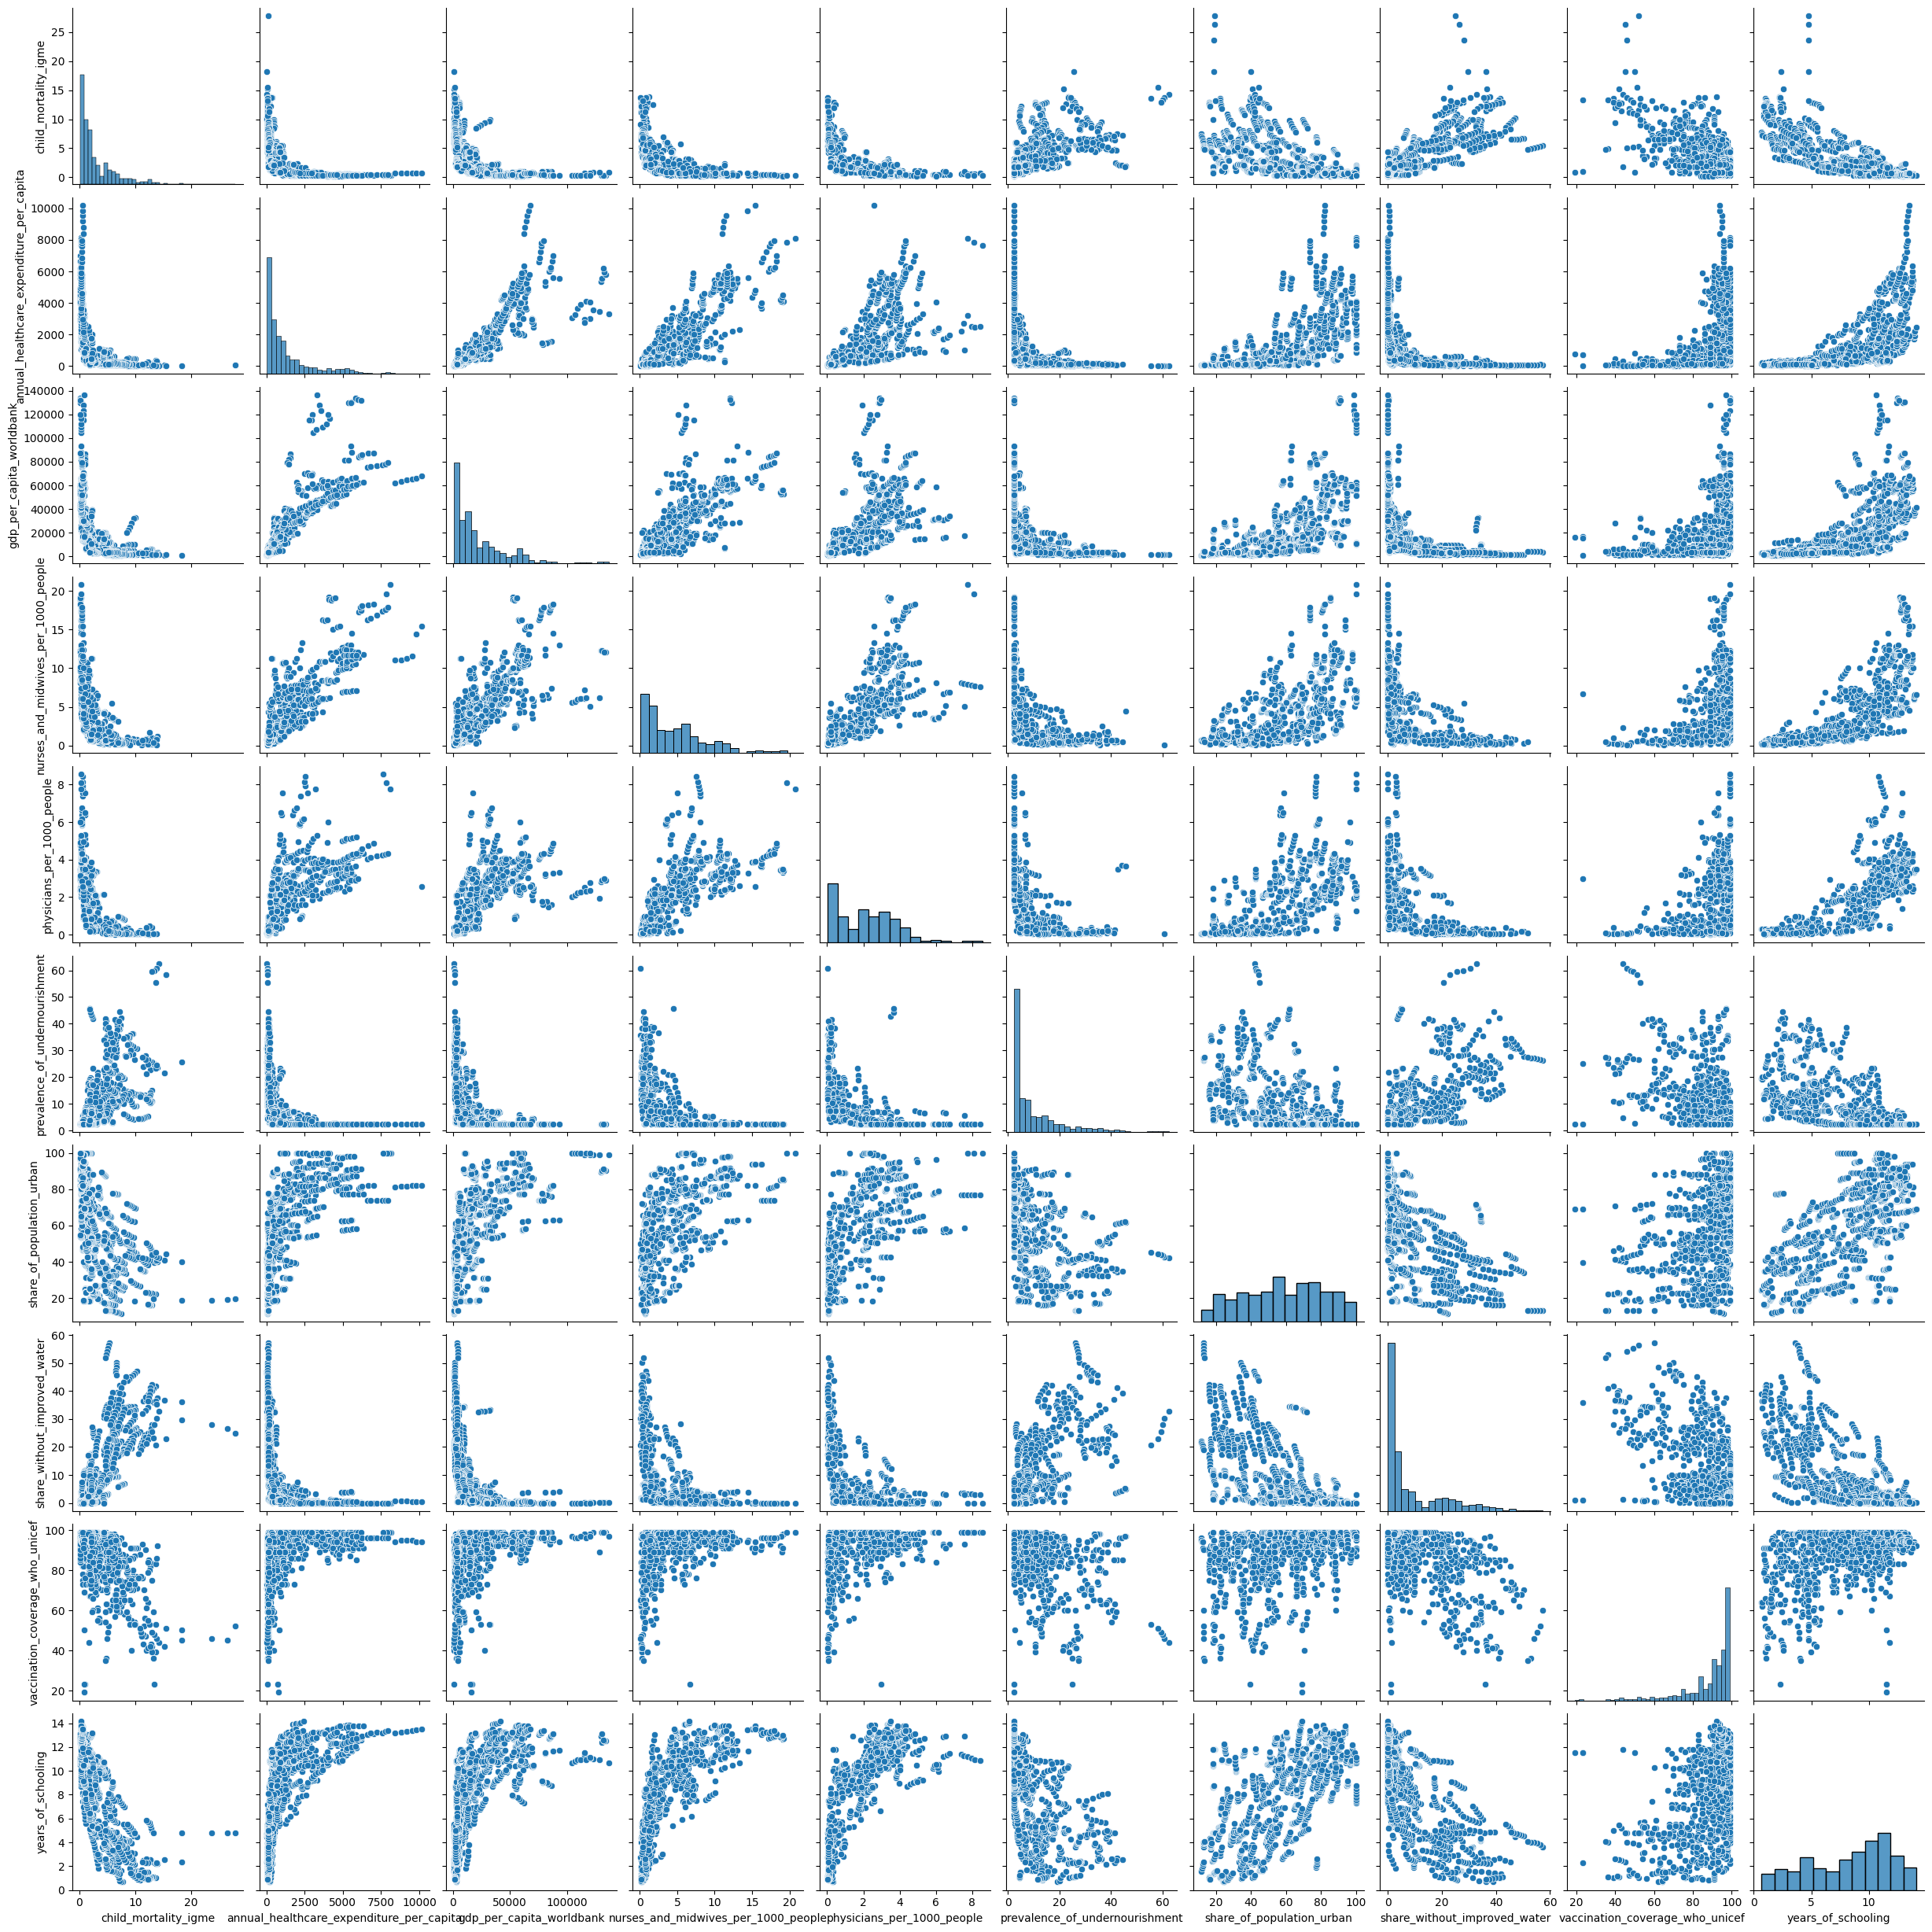

In [79]:
#pairplot all features + label
sns.pairplot(df_main_period)

In [90]:
df_only_features = df_main_period.copy()
df_ony_features = df_only_features.drop(columns=["Entity", "child_mortality_igme"])
corr = df_ony_features.corr()

<Axes: >

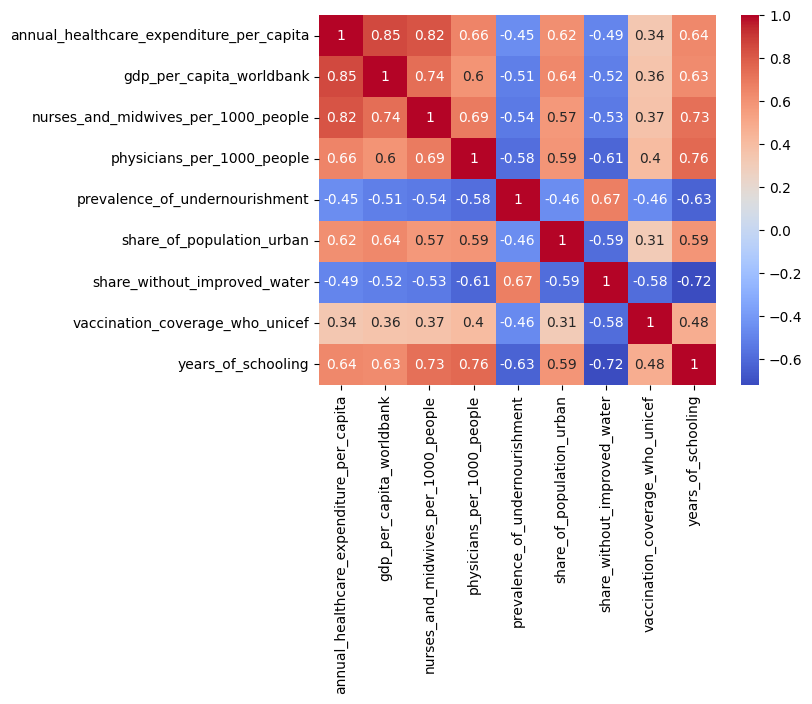

In [91]:
sns.heatmap(corr, annot=True, cmap="coolwarm")

In [86]:
df_main_period.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1200 entries, ('AFG', np.int64(2013)) to ('ZWE', np.int64(2018))
Data columns (total 11 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Entity                                    1200 non-null   object 
 1   child_mortality_igme                      1200 non-null   float64
 2   annual_healthcare_expenditure_per_capita  1142 non-null   float64
 3   gdp_per_capita_worldbank                  1128 non-null   float64
 4   nurses_and_midwives_per_1000_people       862 non-null    float64
 5   physicians_per_1000_people                753 non-null    float64
 6   prevalence_of_undernourishment            1002 non-null   float64
 7   share_of_population_urban                 1170 non-null   float64
 8   share_without_improved_water              1174 non-null   float64
 9   vaccination_coverage_who_unicef           1164 non-null   float64


In [119]:
test = (df_main_period['child_mortality_igme'] < 5).sum()
print(test)

941


<Axes: >

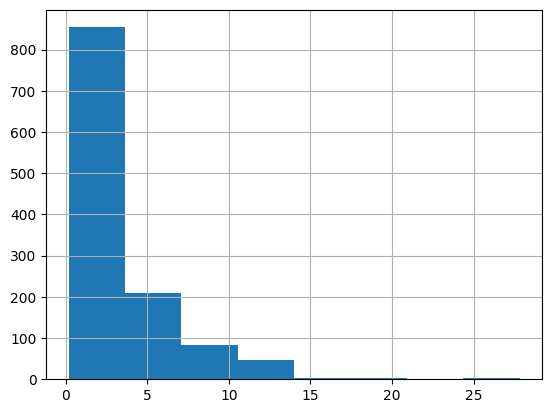

In [120]:
df_main_period['child_mortality_igme'].hist(bins=8)

In [121]:
df_main_period.describe()

,child_mortality_igme,annual_healthcare_expenditure_per_capita,gdp_per_capita_worldbank,nurses_and_midwives_per_1000_people,physicians_per_1000_people,prevalence_of_undernourishment,share_of_population_urban,share_without_improved_water,vaccination_coverage_who_unicef,years_of_schooling
count,1200.000000,1142.000000,1128.000000,862.000000,753.000000,1002.000000,1170.000000,1174.000000,1164.000000,1132.000000
mean,3.064179,1384.140573,22588.782826,4.730940,2.151936,9.836627,58.278545,8.766518,88.289519,8.339549
std,3.352255,1715.310940,23416.547441,4.094242,1.666007,10.225440,23.035379,11.775164,13.337069,3.547940
min,0.174920,25.303010,868.555500,0.101300,0.013000,2.500000,11.482000,0.000000,19.000000,0.672197
25%,0.765550,207.347112,5344.745225,1.349250,0.603000,2.500000,40.047000,0.494207,84.750000,5.268316
50%,1.756699,685.098850,14441.918000,3.913000,2.148000,5.850000,58.026500,3.018631,93.000000,9.004750
75%,4.615378,1805.880075,31796.610500,6.734750,3.299000,13.400000,77.251750,13.830902,97.000000,11.170749
max,27.818722,10182.256000,136454.000000,20.830000,8.568000,62.600000,100.000000,57.326244,99.000000,14.140000
